In [1]:

#Import Libaries--------------

import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

In [2]:
#Config-------------------

batch_size = 4
niters = 10000
nepochs = 10
learning_rate = 0.0002
nworkers = 2

width = 256
height = 256
channels = 3

seed = 44
random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
 class MyDataset(Dataset):
    def __init__(self, root_dir: str, train=True, transforms=None):
        super(MyDataset, self).__init__()
        self.train = train
        self.transforms = transforms
        
        file_path = root_dir + 'Images/*.*'
        file_mask_path = root_dir + 'Masks/*.*'
        
        self.images = sorted(glob(file_path))
        self.image_mask = sorted(glob(file_mask_path))
        
        # manually split the train/valid data
        split_ratio = int(len(self.images) * 0.7)
        if train:
            self.images = self.images[:split_ratio]
            self.image_mask = self.image_mask[:split_ratio]
        else:
            self.images = self.images[split_ratio:]
            self.image_mask = self.image_mask[split_ratio:]
        
        
    def __getitem__(self, index: int):
        image = Image.open(self.images[index]).convert('RGB')
        image_mask = Image.open(self.image_mask[index]).convert('L')

        
        if self.transforms:
            image = self.transforms(image)
            image_mask = self.transforms(image_mask)
                        
        return {'img': image, 'mask': image_mask}
    
    def __len__(self):
        return len(self.images)

In [4]:
transforms = T.Compose([
    T.Resize((width, height)),
    T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
#     T.RandomHorizontalFlip()
])
train_dataset = MyDataset(root_dir='Carvana/',
                                 train=True,
                                 transforms=transforms)
val_dataset = MyDataset(root_dir='Carvana/',
                                train=False,
                                transforms=transforms)

train_dataset_loader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=nworkers)
val_dataset_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=nworkers)

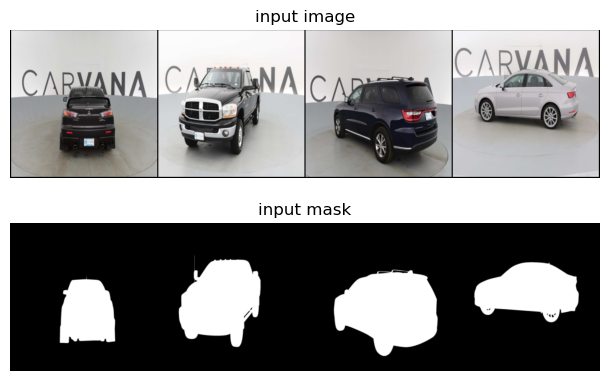

In [5]:
#Sample Data

samples = next(iter(train_dataset_loader))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
fig.tight_layout()

ax1.axis('off')
ax1.set_title('input image')
ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(), (1, 2, 0)))

ax2.axis('off')
ax2.set_title('input mask')
ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),  (1, 2, 0)), cmap='gray')

plt.show()

In [6]:

#Define Netowrk Model

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x: torch.Tensor):
        return self.block(x)
    
class CopyAndCrop(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = T.CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)
        
        return output
    
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()
        
        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        self.down_sample = nn.MaxPool2d(2)
        self.copyAndCrop = CopyAndCrop()
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])

        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])

        
        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
    def forward(self, x: torch.Tensor):
        # encod
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)
            
        
        x = self.bottleneck(x)
        
        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.copyAndCrop(x, encoded)
            x = denc(x)
            
        output = self.final_conv(x)
        return output

In [7]:
#Metrics

def dice_score(pred: torch.Tensor, mask: torch.Tensor):
    dice = (2 * (pred * mask).sum()) / (pred + mask).sum()
    return np.mean(dice.cpu().numpy())

def iou_score(pred: torch.Tensor, mask: torch.Tensor):
    pass

def pixel_accuracy(pred: torch.Tensor, mask: torch.Tensor):
    correct = torch.eq(pred, val_mask).int()
    return float(correct.sum()) / float(correct.numel())

In [8]:
#Train

def plot_pred_img(samples, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
    fig.tight_layout()


    ax1.axis('off')
    ax1.set_title('input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),  (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(), (1, 2, 0)), cmap='gray')
    
    ax3.axis('off')
    ax3.set_title('predicted mask')
    ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(), (1, 2, 0)), cmap='gray')

    plt.show()
    
    
def plot_train_progress(model):
    samples = next(iter(val_dataset_loader))
    val_img = samples['img'].to(device)
    val_mask = samples['mask'].to(device)

    pred = model(val_img)

    plot_pred_img(samples, pred.detach())

In [11]:
def train(model, optimizer, criteration, scheduler=None):
    train_losses = []
    val_lossess = []
    lr_rates = []
    
    # calculate train epochs
    epochs = int(niters / (len(train_dataset) / batch_size))

    for epoch in range(epochs):
        model.train()        
        train_total_loss = 0
        train_iterations = 0
        
        for idx, data in enumerate(tqdm(train_dataset_loader)):
            train_iterations += 1
            train_img = data['img'].to(device)
            train_mask = data['mask'].to(device)
            
            optimizer.zero_grad()
            # speed up the training
            with torch.autocast(device_type='cuda'):
                train_output_mask = model(train_img)
                train_loss = criterion(train_output_mask, train_mask)
                train_total_loss += train_loss.item()

            train_loss.backward()
            optimizer.step()

        train_epoch_loss = train_total_loss / train_iterations
        train_losses.append(train_epoch_loss)
        
        # evaluate mode
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_iterations = 0
            scores = 0

            for vidx, val_data in enumerate(tqdm(val_dataset_loader)):
                val_iterations += 1
                val_img = val_data['img'].to(device)
                val_mask = val_data['mask'].to(device)

                with torch.autocast(device_type='cuda'):
                    pred = model(val_img)
                    val_loss = criterion(pred, val_mask)
                    val_total_loss += val_loss.item()
                    scores += dice_score(pred, val_mask)


            val_epoch_loss = val_total_loss / val_iterations
            dice_coef_scroe = scores / val_iterations

            val_lossess.append(val_epoch_loss)           

            plot_train_progress(model)
            print('epochs - {}/{} [{}/{}], dice score: {}, train loss: {}, val loss: {}'.format(
                epoch+1, epochs, idx+1, len(train_dataset_loader), dice_coef_scroe, train_epoch_loss, val_epoch_loss )) 
            
        lr_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            # decay learning rate
            scheduler.step() 
            print('LR rate:', scheduler.get_last_lr())
            
    return {
        'lr': lr_rates,
        'train_loss': train_losses,
        'valid_loss': val_lossess
    }
         

In [ ]:
model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
# criterion = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, optimizer, criterion)

  0%|                                                                                                               | 0/891 [00:00<?, ?it/s]/home/picox/uopt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
 19%|███████████████████▏                                                                               | 173/891 [28:30<1:48:24,  9.06s/it]

In [ ]:
#Visualize Result

plt.plot(history['train_loss'], label='constant LR train loss')
plt.plot(history['valid_loss'], label='constant LR val loss')

plt.plot(history2['train_loss'], label='schdule LR train loss')
plt.plot(history2['valid_loss'], label='schdule LR val loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()